In [117]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nlp_id.stopword import StopWord 
from nlp_id.postag import PosTag
from nltk.tokenize import sent_tokenize
import torch
from nlp_id.lemmatizer import Lemmatizer 
from googletrans import Translator
import regex
from fuzzysearch import find_near_matches
from datetime import datetime
from multiprocessing import  Pool
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pandarallel import pandarallel

In [118]:
df = pd.read_csv("bert_sentiment.csv", index_col = 0)
df["Date"] = pd.to_datetime(df["Trading Date"])

## Stock Universe

In [119]:
len(df["Final Ticker"].unique())

706

In [298]:
df[df["Sentiment"] == "positive"]["title"].iloc[5]

'Optimistis Ekonomi Baik, BRI Kerek Target Kredit Jadi 14%'

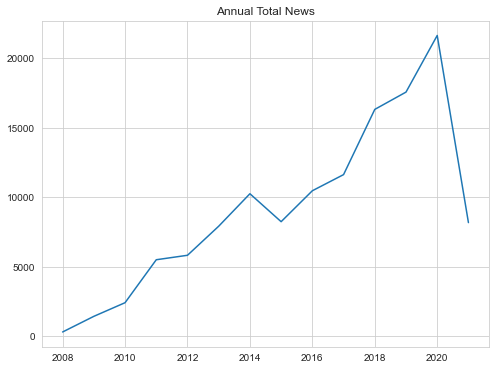

In [241]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.plot(df[["Year", "Sentiment"]].groupby("Year").count())
plt.title("Annual Total News")
plt.savefig('numdat.png')
plt.show()

In [121]:
filtered = df.loc[df["Date"] > datetime(2015,1,1)]

In [122]:
test = filtered[["Final Ticker", "Sentiment"]].groupby("Final Ticker").count().sort_values("Sentiment")

In [195]:
test

,Sentiment
Final Ticker,
PNLF,1
PMJS,1
INCI,1
AMAR,2
PRAS,3
...,...
BBCA,3397
ANTM,4113
BBNI,4624


In [123]:
np.quantile(test, q = [0.99, 0.8, 0.5, 0.2, 0.01])

array([1393.,  111.,   34.,   13.,    4.])

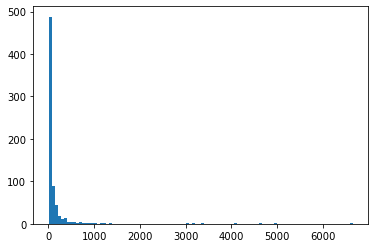

In [124]:
plt.hist(test, bins = 100)
plt.show()

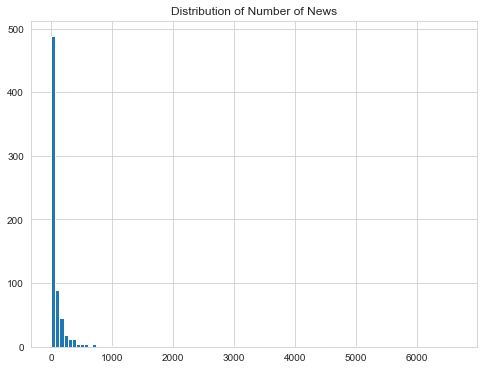

In [239]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.hist(test, bins = 100)
plt.title("Distribution of Number of News")
plt.savefig('distribution.png')
plt.show()

In [125]:
names = list(test[test["Sentiment"] > 50].index)

In [126]:
df.columns.intersection(names)

Index([], dtype='object')

### Market Variable

In [127]:
price_stock = pd.read_csv("PX_LAST20020101.csv")
price_stock["Date"] = pd.to_datetime(price_stock["Date"], format = "%Y%m%d")
price_stock = price_stock.set_index("Date").loc[datetime(2015,2,12):datetime(2021,5,31)]
ret_stock = price_stock.pct_change().loc[datetime(2015,1,1):datetime(2021,5,31)]

ret_stock.index = pd.to_datetime(ret_stock.index)
ret_stock_m = (price_stock.resample('M')
               .last().pct_change()
               .shift(-1)
               .loc[datetime(2015,1,1):datetime(2021,5,31)])



jci = pd.read_excel("JCI.xlsx")
jci = jci.set_index("Unnamed: 0").loc[datetime(2015,2,12):datetime(2021,5,31)]
jci_m = jci.resample('M').last().pct_change().shift(-1).loc[datetime(2015,2,12):datetime(2021,5,31)]

market_cap = pd.read_csv("MKT_CAP 20020101.csv")
market_cap["Date"] = pd.to_datetime(market_cap["Date"], format = "%Y%m%d")
market_cap = market_cap.set_index("Date").loc[datetime(2015,2,12):datetime(2021,5,31)]
market_cap_m = market_cap.resample('M').last().loc[datetime(2015,2,12):datetime(2021,5,31)]

In [128]:
grouped = filtered.groupby(["Date", "Sentiment", "Final Ticker"]).size().unstack(level = -1).unstack(level = -1).fillna(0)

In [129]:
def score_scheme(row):
    tot = row["positive"] + row["negative"]
    if tot <= 0:
        return 0
    else:
        return (row["positive"] - row["negative"])/tot

In [148]:
score = (grouped
         .groupby(axis = 1, level = 0)
         .apply(lambda x: x[x.name]
                .apply(score_scheme, axis = 1)))

In [149]:
roll_coef = 30
roll = score.rolling(roll_coef).mean()

In [150]:
change = score - roll

In [151]:
halflife_coef = 10
trading_signal = (change.apply(lambda x: 
                               x.ewm(halflife = halflife_coef)
                               .mean(), axis = 1)).dropna()

In [152]:
count = (filtered[["Final Ticker", "Sentiment"]]
         .groupby("Final Ticker").count()
         .sort_values("Sentiment"))
names = list(count[count["Sentiment"] > 50].index)

In [153]:
trading_signal = trading_signal[trading_signal.columns.intersection(names)]
trading_signal = trading_signal[trading_signal.columns.intersection(market_cap.columns)]

In [154]:
stocks = list(trading_signal.columns)

In [223]:
corr = []
marketcap = []
firm = []
n_data = []


for i in trading_signal.columns:
    t = (trading_signal[i]
     .rename("T")
     .to_frame()
     .merge(ret_stock[i].rename("R"), how = 'inner', left_index = True,
                           right_index = True)
     .dropna())
    corr.append(np.corrcoef(t["T"], t["R"])[0,1])
    marketcap.append(np.log(market_cap[i].tail(1)[0]))
    firm.append(i)
    n_data.append(np.log(test.loc[i]))

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


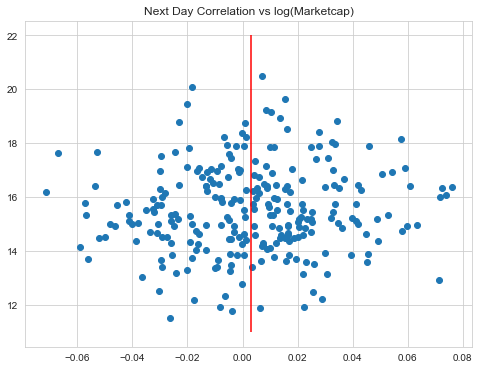

In [225]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.scatter(x = corr, y = marketcap)
plt.title("Next Day Correlation vs log(Marketcap)")
plt.vlines(np.nanmean(corr), ymin = 11, ymax = 22, color = "red")
plt.savefig('correlation.png')
plt.show()

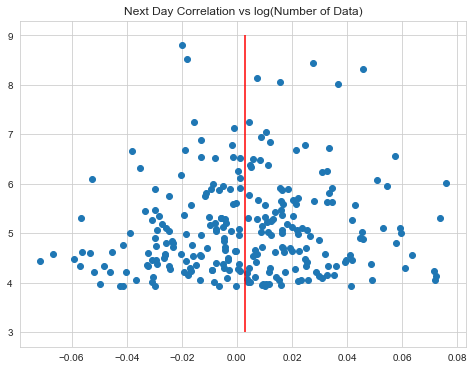

In [228]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.scatter(x = corr, y = n_data)
plt.vlines(np.nanmean(corr), ymin = 3, ymax = 9, color = "red")
plt.title("Next Day Correlation vs log(Number of Data)")
plt.savefig('numdat.png')
plt.show()

In [159]:
pd.DataFrame({"Correlation" : corr, "Marketcap" : marketcap}).corr()

,Correlation,Marketcap
Correlation,1.000000,0.059275
Marketcap,0.059275,1.000000


In [160]:
pd.DataFrame({"Correlation" : corr, "Marketcap" : marketcap}).mean()

Correlation     0.003001
Marketcap      15.534910
dtype: float64

In [161]:
trading_signal.loc[datetime(2018,2,1)]

Final Ticker
AALI    0.000000
ABBA    0.000000
ABMM    0.000000
ACES   -0.007621
ACST   -0.006121
          ...   
WSBP   -0.001475
WSKT   -0.001376
WTON   -0.001284
ZBRA   -0.000973
ZINC   -0.000908
Name: 2018-02-01 00:00:00, Length: 257, dtype: float64

In [162]:
def portfolio(holding_period, n):
    prices = price_stock[price_stock.index.isin(trading_signal.index)]
    jcis = jci[jci.index.isin(trading_signal.index)]
    mktcp = market_cap[market_cap.index.isin(trading_signal.index)]
    returns = (price_stock
               .resample(holding_period)
               .last()
               .shift(-1)
               .pct_change())
    signals = (trading_signal
               .resample(holding_period)
               .last())
    jci_returns = (jcis
               .resample(holding_period)
               .last()
               .shift(-1)
               .pct_change())
    mktcps = (mktcp
               .resample(holding_period)
               .mean()
            .shift(-1))
    chosen = signals.apply(lambda s: s.nlargest(n).index.tolist(), axis=1)
    
    rets = []
    for i in list(chosen.index):
        ret_temp = []
        for j in chosen.loc[i]:
            ret_temp.append(returns.loc[i,j])
        
        weights_temp = []
        for j in chosen.loc[i]:
            weights_temp.append(signals.loc[i,j])
        
        market_temp = []
        for j in chosen.loc[i]:
            market_temp.append(mktcps.loc[i,j])
            
        include = []

        for j in market_temp:
            if j < 500000:
                include.append(0)
            else:
                include.append(1)
    
        weights_temp = [a * b for a, b in zip(weights_temp, include)]/np.sum([a * b for a, b in zip(weights_temp, include)])
        
        rets.append(np.sum([a * b for a, b in zip(weights_temp, ret_temp)]))

        
    
    return pd.DataFrame({"Return": rets, "JCI": jci_returns["JCI"], "Chosen": chosen}, index = chosen.index)

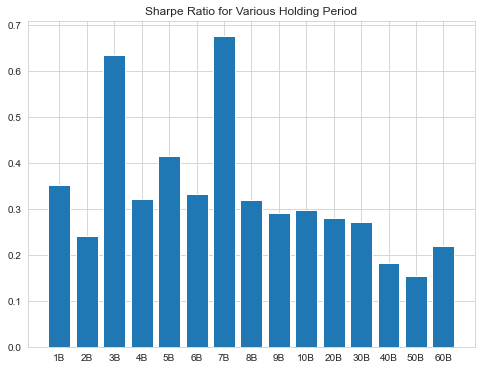

In [256]:
IRs = []
exp_ret = []
periods = ['1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', 
           '20B','30B', '40B', '50B', '60B']
p = [250, 250/2, 250/3, 250/4, 250/5, 250/6, 250/7, 250/8, 250/9, 250/10,
    250/20, 250/30, 250/40, 250/50, 250/60]
for i in range(len(periods)):
    rets = portfolio(periods[i], 50)
    IRs.append((np.mean(rets["Return"])*p[i] - 0.0435) /(np.std(rets["Return"]) * np.sqrt(p[i])))
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.bar(periods, IRs)
plt.title("Sharpe Ratio for Various Holding Period")
plt.savefig('sharpesw.png')
plt.show()

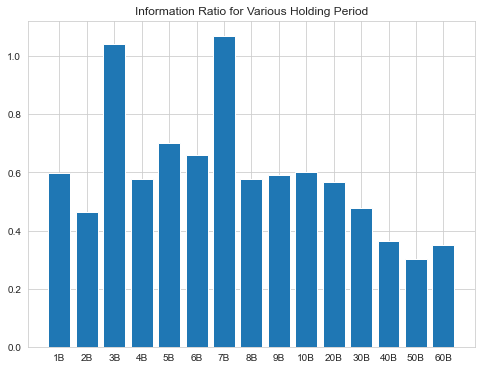

In [257]:
IRs = []
exp_ret = []
periods = ['1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', 
           '20B','30B', '40B', '50B', '60B']
p = [250, 250/2, 250/3, 250/4, 250/5, 250/6, 250/7, 250/8, 250/9, 250/10,
    250/20, 250/30, 250/40, 250/50, 250/60]
for i in range(len(periods)):
    rets = portfolio(periods[i], 50)
    IRs.append(np.mean(rets["Return"] - rets["JCI"])* np.sqrt(p[i])/(np.std(rets["Return"]- rets["JCI"])))
    
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.bar(periods, IRs)
plt.title("Information Ratio for Various Holding Period")
plt.savefig('IRsw.png')
    

plt.show()

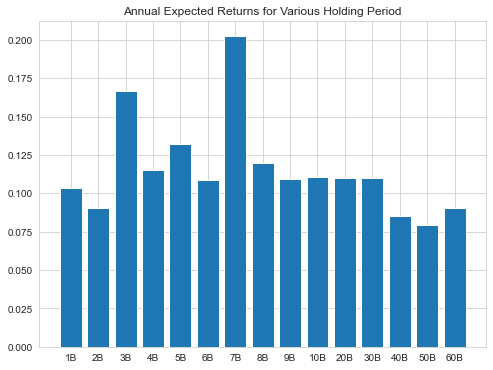

In [254]:
IRs = []
exp_ret = []
periods = ['1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', 
           '20B','30B', '40B', '50B', '60B']
p = [250, 250/2, 250/3, 250/4, 250/5, 250/6, 250/7, 250/8, 250/9, 250/10,
    250/20, 250/30, 250/40, 250/50, 250/60]
for i in range(len(periods)):
    rets = portfolio(periods[i], 50)
    IRs.append((np.mean(rets["Return"])*p[i] - 0.06) /(np.std(rets["Return"]) * np.sqrt(p[i])))
    exp_ret.append(np.mean(rets["Return"])*p[i]) 
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.bar(periods, exp_ret)
plt.title("Annual Expected Returns for Various Holding Period")
plt.savefig('ERsw.png')
plt.show()


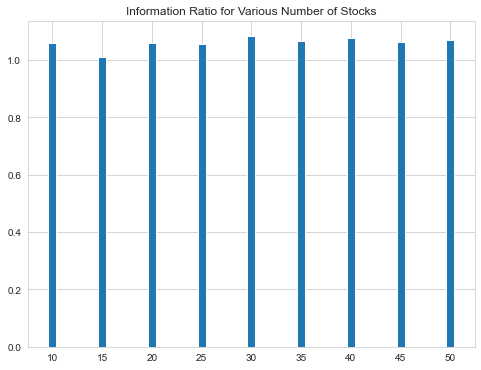

In [273]:
IRs = []
exp_ret = []
nstock = [10, 15, 20, 25, 30, 35, 40, 45, 50]
for i in nstock:
    rets = portfolio('7B', i)
    IRs.append(np.mean(rets["Return"] - rets["JCI"])* np.sqrt(250/7)/(np.std(rets["Return"]- rets["JCI"])))
    exp_ret.append(np.mean(rets["Return"])*4) 
    
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.bar(nstock, IRs)
plt.title("Information Ratio for Various Number of Stocks")
plt.savefig('Nstock2sw.png')
plt.show()

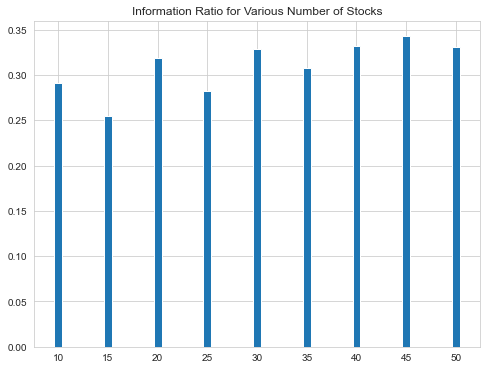

In [274]:
IRs = []
exp_ret = []
nstock = [10, 15, 20, 25, 30, 35, 40, 45, 50]
for i in nstock:
    rets = portfolio('30B', i)
    IRs.append(np.mean(rets["Return"] - rets["JCI"])* np.sqrt(4)/(np.std(rets["Return"]- rets["JCI"])))
    exp_ret.append(np.mean(rets["Return"])*4) 
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.bar(nstock, IRs)
plt.title("Information Ratio for Various Number of Stocks")
plt.savefig('Nstock3sw.png')
plt.show()


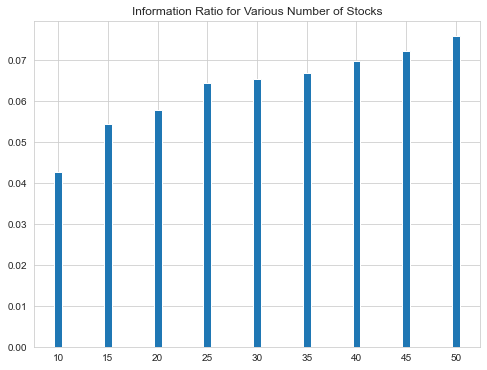

In [275]:
IRs = []
exp_ret = []
nstock = [10, 15, 20, 25, 30, 35, 40, 45, 50]
for i in nstock:
    rets = portfolio('1B', i)
    IRs.append(np.mean(rets["Return"] - rets["JCI"])* np.sqrt(4)/(np.std(rets["Return"]- rets["JCI"])))
    exp_ret.append(np.mean(rets["Return"])*4) 
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.bar(nstock, IRs)
plt.title("Information Ratio for Various Number of Stocks")
plt.savefig('Nstock1sw.png')
plt.show()

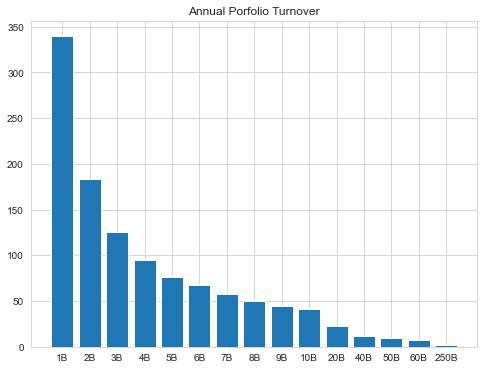

In [276]:
PTs = []
periods = ['1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', 
          '7B', '20B', '40B', '50B', '60B',
          '250B']
p = [250, 250/2, 250/3, 250/4, 250/5, 250/6, 250/7, 250/8, 250/9, 250/10,
    250/7, 250/20, 250/40, 250/50, 250/60,
    1]
for i in range(len(periods)):
    pt = portfolio_turnover(periods[i], 50)
    PTs.append(pt/6)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.bar(periods, PTs)
plt.title("Annual Porfolio Turnover")
plt.savefig('PT.png')
plt.show()

In [ ]:
IRs = []
exp_ret = []
nstock = [10, 15, 20, 25, 30, 35, 40, 45, 50]
for i in nstock:
    rets = portfolio('3B', i)
    IRs.append(np.mean(rets["Return"] - rets["JCI"])* np.sqrt(4)/(np.std(rets["Return"]- rets["JCI"])))
    exp_ret.append(np.mean(rets["Return"])*4) 
plt.bar(nstock, IRs)
plt.show()

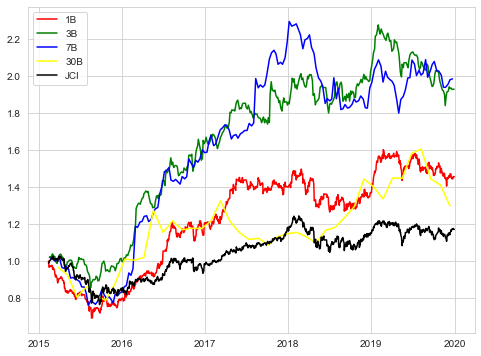

In [263]:
rets1 = portfolio('1B', 50)
rets1 = rets1[rets1.index < datetime(2020,1,1)]
cumret1 = (rets1["Return"] + 1).cumprod()
jci_cumret = (rets1["JCI"] + 1).cumprod()
rets2 = portfolio('3B', 50)
rets2 = rets2[rets2.index < datetime(2020,1,1)]
cumret2 = (rets2["Return"] + 1).cumprod()
rets3 = portfolio('7B', 50)
rets3 = rets3[rets3.index < datetime(2020,1,1)]
cumret3 = (rets3["Return"] + 1).cumprod()
rets4 = portfolio('30B', 50)
rets4 = rets4[rets4.index < datetime(2020,1,1)]
cumret4 = (rets4["Return"] + 1).cumprod()

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.plot(cumret1, color = "red", label = "1B")
plt.plot(cumret2, color = "green", label = "3B")
plt.plot(cumret3, color = "blue", label = "7B")
plt.plot(cumret4, color = "yellow", label = "30B")

plt.plot(jci_cumret, color = "black", label = "JCI")
plt.legend(loc="upper left")
plt.savefig('cumretsw.png')
plt.show()

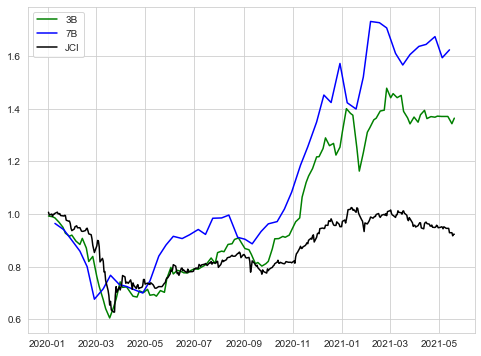

In [264]:
rets1 = portfolio('1B', 50)
rets1 = rets1[rets1.index > datetime(2020,1,1)]
cumret1 = (rets1["Return"] + 1).cumprod()
jci_cumret = (rets1["JCI"] + 1).cumprod()
rets2 = portfolio('3B', 50)
rets2 = rets2[rets2.index > datetime(2020,1,1)]
cumret2 = (rets2["Return"] + 1).cumprod()
rets3 = portfolio('7B', 50)
rets3 = rets3[rets3.index > datetime(2020,1,1)]
cumret3 = (rets3["Return"] + 1).cumprod()

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.plot(cumret2, color = "green", label = "3B")
plt.plot(cumret3, color = "blue", label = "7B")

plt.plot(jci_cumret, color = "black", label = "JCI")
plt.legend(loc="upper left")
plt.savefig('cumretossw.png')
plt.show()

In [173]:
def portfolio_m(holding_period, n):
    prices = price_stock[price_stock.index.isin(trading_signal.index)]
    jcis = jci[jci.index.isin(trading_signal.index)]
    mktcp = market_cap[market_cap.index.isin(trading_signal.index)]
    returns = (price_stock
               .resample(holding_period)
               .last()
               .shift(-1)
               .pct_change())
    signals = (trading_signal
               .resample(holding_period)
               .last())
    jci_returns = (jcis
               .resample(holding_period)
               .last()
               .shift(-1)
               .pct_change())
    mktcps = (mktcp
               .resample(holding_period)
               .mean()
            .shift(-1))
    chosen = signals.apply(lambda s: s.nlargest(n).index.tolist(), axis=1)
    
    rets = []
    for i in list(chosen.index):
        ret_temp = []
        for j in chosen.loc[i]:
            ret_temp.append(returns.loc[i,j])
        
        weights_temp = []
        for j in chosen.loc[i]:
            weights_temp.append(signals.loc[i,j])
        
        market_temp = []
        for j in chosen.loc[i]:
            market_temp.append(mktcps.loc[i,j])
            
        include = []

        for j in market_temp:
            if j < 500000:
                include.append(0)
            else:
                include.append(1)
    
        weights_temp = [a * b for a, b in zip(market_temp, include)]/np.sum([a * b for a, b in zip(market_temp, include)])
        
        rets.append(np.sum([a * b for a, b in zip(weights_temp, ret_temp)]))

        
    
    return pd.DataFrame({"Return": rets, "JCI": jci_returns["JCI"], "Chosen": chosen}, index = chosen.index)

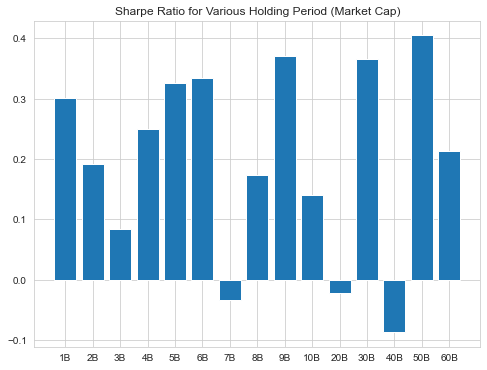

In [284]:
IRs = []
exp_ret = []
periods = ['1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', 
           '20B','30B', '40B', '50B', '60B']
p = [250, 250/2, 250/3, 250/4, 250/5, 250/6, 250/7, 250/8, 250/9, 250/10,
    250/20, 250/30, 250/40, 250/50, 250/60]
for i in range(len(periods)):
    rets = portfolio_m(periods[i], 50)
    IRs.append((np.mean(rets["Return"])*p[i] - 0.06) /(np.std(rets["Return"]) * np.sqrt(p[i])))

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.bar(periods, IRs)
plt.title("Sharpe Ratio for Various Holding Period (Market Cap)")
plt.savefig('sharpeswmc.png')
plt.show()


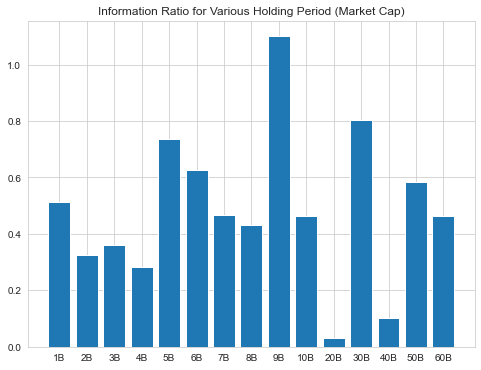

In [283]:
IRs = []
exp_ret = []
periods = ['1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', 
           '20B','30B', '40B', '50B', '60B']
p = [250, 250/2, 250/3, 250/4, 250/5, 250/6, 250/7, 250/8, 250/9, 250/10,
    250/20, 250/30, 250/40, 250/50, 250/60]
for i in range(len(periods)):
    rets = portfolio_m(periods[i], 30)
    IRs.append(np.mean(rets["Return"] - rets["JCI"])* np.sqrt(p[i])/(np.std(rets["Return"]- rets["JCI"])))

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.bar(periods, IRs)
plt.title("Information Ratio for Various Holding Period (Market Cap)")
plt.savefig('IRswmc.png')
plt.show()

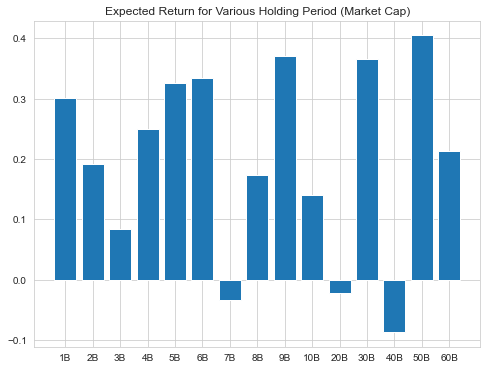

In [282]:
IRs = []
exp_ret = []
periods = ['1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', 
           '20B','30B', '40B', '50B', '60B']
p = [250, 250/2, 250/3, 250/4, 250/5, 250/6, 250/7, 250/8, 250/9, 250/10,
    250/20, 250/30, 250/40, 250/50, 250/60]
for i in range(len(periods)):
    rets = portfolio_m(periods[i], 50)
    IRs.append((np.mean(rets["Return"])*p[i] - 0.06) /(np.std(rets["Return"]) * np.sqrt(p[i])))
    exp_ret.append(np.mean(rets["Return"])*p[i]) 
    

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.bar(periods, IRs)
plt.title("Expected Return for Various Holding Period (Market Cap)")
plt.savefig('ERswmc.png')
plt.show()

In [177]:
def portfolio_ls(holding_period, n):
    prices = price_stock[price_stock.index.isin(trading_signal.index)]
    jcis = jci[jci.index.isin(trading_signal.index)]
    mktcp = market_cap[market_cap.index.isin(trading_signal.index)]
    returns = (price_stock
               .resample(holding_period)
               .last()
               .shift(-1)
               .pct_change())
    signals = (trading_signal
               .resample(holding_period)
               .last())
    jci_returns = (jcis
               .resample(holding_period)
               .last()
               .shift(-1)
               .pct_change())
    mktcps = (mktcp
               .resample(holding_period)
               .mean()
            .shift(-1))
    chosenp = signals.apply(lambda s: s.nlargest(n/2).index.tolist(), axis=1)
    chosenn = signals.apply(lambda s: s.nsmallest(n/2).index.tolist(), axis=1)
    for i in list(chosen.index):
        ret_temp = []
        for j in chosen.loc[i]:
            ret_temp.append(returns.loc[i,j])
        
        weights_temp = []
        for j in chosen.loc[i]:
            weights_temp.append(signals.loc[i,j])
        
        market_temp = []
        for j in chosen.loc[i]:
            market_temp.append(mktcps.loc[i,j])
            
        include = []

        for j in market_temp:
            if j < 500000:
                include.append(0)
            else:
                include.append(1)
    
        weights_temp = [a * b for a, b in zip(weights_temp, include)]/np.sum([a * b for a, b in zip(weights_temp, include)])
        
        rets.append(np.sum([a * b for a, b in zip(weights_temp, ret_temp)]))


    
    return pd.DataFrame({"Return": rets, "JCI": jci_returns["JCI"], "Chosen": chosen}, index = chosen.index)

In [178]:
def portfolio_turnover(holding_period, n):
    prices = price_stock[price_stock.index.isin(trading_signal.index)]
    mktcp = market_cap[market_cap.index.isin(trading_signal.index)]
    returns = (price_stock
               .resample(holding_period)
               .last()
               .shift(-1)
               .pct_change())
    signals = (trading_signal
               .resample(holding_period)
               .last())
    mktcps = (mktcp
               .resample(holding_period)
               .mean()
            .shift(-1))
    chosen = signals.apply(lambda s: s.nlargest(n).index.tolist(), axis=1)
    d1 = dict.fromkeys(signals.columns)
    
    for i in d1:
        d1[i] = 0
    
    change = []
    for i in list(chosen.index):
    
        weights_temp = []
        for j in chosen.loc[i]:
            weights_temp.append(signals.loc[i,j])
    
        market_temp = []
        for j in chosen.loc[i]:
            market_temp.append(mktcps.loc[i,j])
    
        include = []
    
        for j in market_temp:
            if j < 500000:
                include.append(0)
            else:
                include.append(1)
    
        weights_temp = [a * b for a, b in zip(weights_temp, include)]/np.sum([a * b for a, b in zip(weights_temp, include)])
    
        d_temp = {}
        for j in range(len(chosen.loc[i])):
            d_temp[str(chosen.loc[i][j])] = weights_temp[j]
    
        diff = {key: abs(d1[key] - d_temp.get(key, 0)) for key in d1}
        change.append(sum(diff.values()))
        
        d1 = dict.fromkeys(signals.columns)
    
        for t in d1:
            d1[t] = 0
    
        d1 = {key: d1[key] + d_temp.get(key, 0) for key in d1}
    return sum(change)

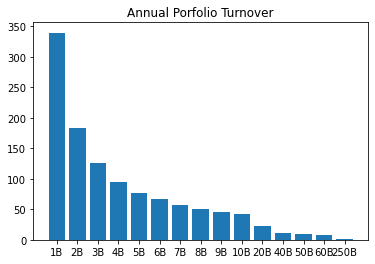

In [192]:
PTs = []
periods = ['1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', 
          '7B', '20B', '40B', '50B', '60B',
          '250B']
p = [250, 250/2, 250/3, 250/4, 250/5, 250/6, 250/7, 250/8, 250/9, 250/10,
    250/7, 250/20, 250/40, 250/50, 250/60,
    1]
for i in range(len(periods)):
    pt = portfolio_turnover(periods[i], 50)
    PTs.append(pt/6)
     
plt.bar(periods, PTs)
plt.title("Annual Porfolio Turnover")
plt.show()